# 1. Introduction

Wikipedia - 'Kickstarter is an American public-benefit corporation based in Brooklyn, New York, that maintains a global crowdfunding platform focused on creativity and merchandising'

In this notebook we'll try to find out which crowdfunding projects are going to be succeed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [3]:
raw_data = pd.read_csv('ks-projects-201801.csv')

In [4]:
raw_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
raw_data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


# 2. Data, data preparation

Below is located the code checking if columns contain null values

In [7]:
raw_data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

New dataframe without null values is going to be created using raw_data dataframe.

In [8]:
cleaned_data = raw_data.dropna()

In [9]:
cleaned_data.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

Few features are string type numbers. There is a need to change it into numeric type.

In [10]:
#coerce - invalid parsing will be set as NaN
cleaned_data.usd_goal_real = pd.to_numeric(cleaned_data.usd_goal_real, errors='coerce')
cleaned_data.usd_pledged_real = pd.to_numeric(cleaned_data.usd_pledged_real, errors='coerce')
cleaned_data.backers = pd.to_numeric(cleaned_data.backers, errors='coerce')
cleaned_data.pledged = pd.to_numeric(cleaned_data.pledged, errors='coerce')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# 2.1. Categories

Let's look at the data.

Text(0,0.5,'Number of projects')

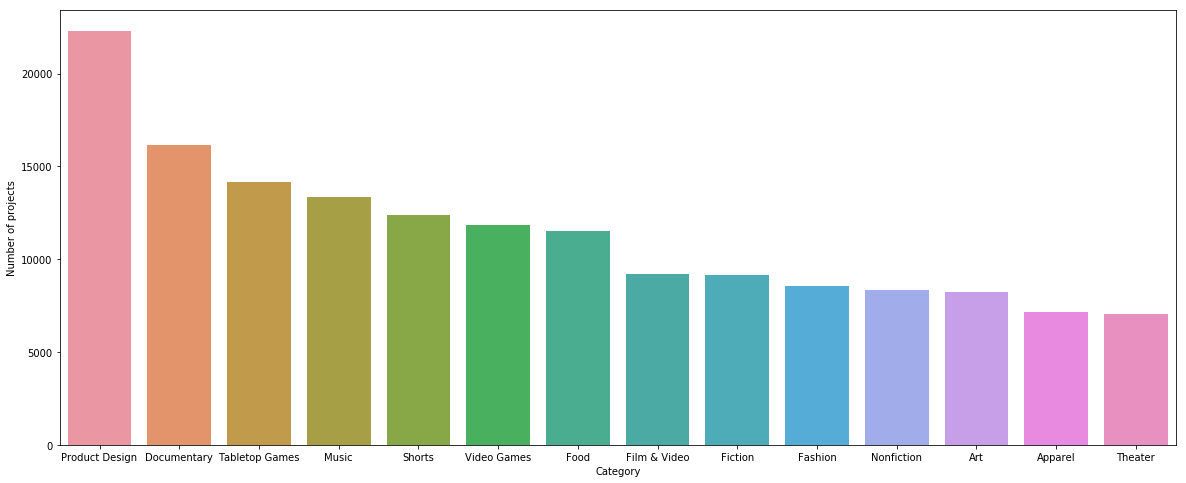

In [11]:
category_df = pd.DataFrame(cleaned_data.groupby(cleaned_data['category'])['ID'].count())
category_df.rename(columns={'ID' : 'number_of_projects'}, inplace=True)

category_df.groupby('category')['number_of_projects']
category_df = category_df.sort_values(by='number_of_projects', ascending = False).reset_index().head(14)
plt.figure(figsize=(20,8));
category_plot = sns.barplot(x='category', y='number_of_projects', data = category_df)
category_plot.set_xlabel('Category')
category_plot.set_ylabel('Number of projects')

In [12]:
cleaned_data['launched'] = pd.to_datetime(cleaned_data['launched'])
cleaned_data['deadline'] = pd.to_datetime(cleaned_data['deadline'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 2.2. State and finding the fake record(s)

Now there is possibility to check how many successfull projects were launched in specific years.

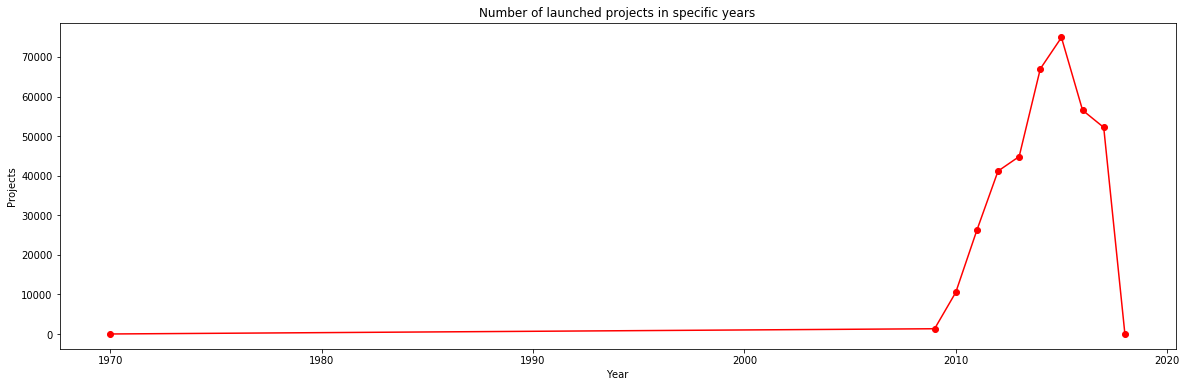

In [13]:
project_plot = pd.DataFrame(cleaned_data.groupby(cleaned_data['launched'].dt.year)['ID'].count())
project_plot = project_plot.reset_index()
project_plot.rename(columns={'ID': 'projects'}, inplace=True)

plt.figure(figsize=(20,6));
plt.plot(project_plot['launched'], project_plot['projects'],'-yo', color="red")
plt.xlabel('Year')
plt.ylabel('Projects')
plt.title('Number of launched projects in specific years')
plt.show()

Here an anomaly was found. There are at least one successfull project in the data which was launched in 1970 despite the fact that Kickstarter was fund in... 2009. Every record containing dates < 28/04/08 (British format) is going to be deleted. It is applied to 2018 (no data) also.

In [14]:
cleaned_data = cleaned_data[(cleaned_data['launched'] > '2009-04-28') & (cleaned_data['launched'] <= '2018-01-01')]

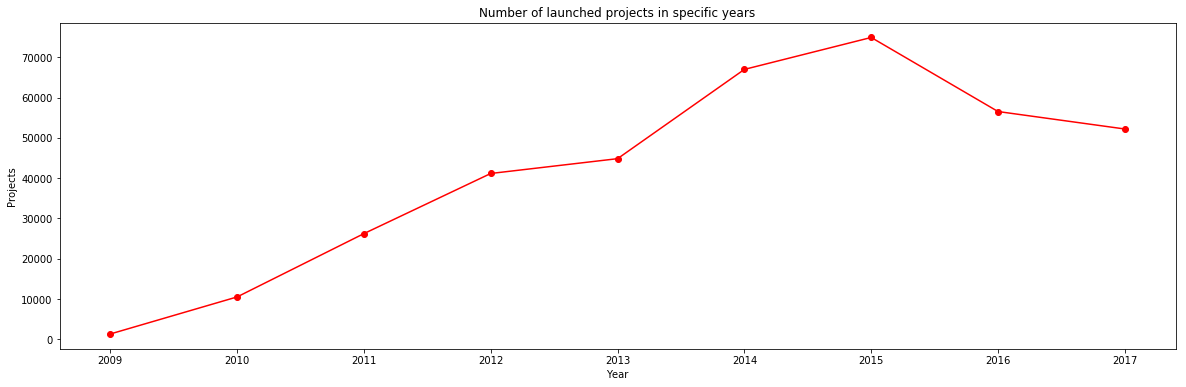

In [15]:
project_plot = pd.DataFrame(cleaned_data.groupby(cleaned_data['launched'].dt.year)['ID'].count())
project_plot = project_plot.reset_index()
project_plot.rename(columns={'ID': 'projects'}, inplace=True)

plt.figure(figsize=(20,6));
plt.plot(project_plot['launched'], project_plot['projects'],'-yo', color="red")
plt.xlabel('Year')
plt.ylabel('Projects')
plt.title('Number of launched projects in specific years')
plt.show()

Bar graph below shows number of projects in specific years according to states of those projects. There was considered pie chart but the decision was to abandon this idea to ensure clarity (bar graph is more suitable for visualising the data).

In [16]:
year_state_counted = cleaned_data.groupby([cleaned_data['launched'].dt.year, 'state']).size().to_frame('counted').reset_index()

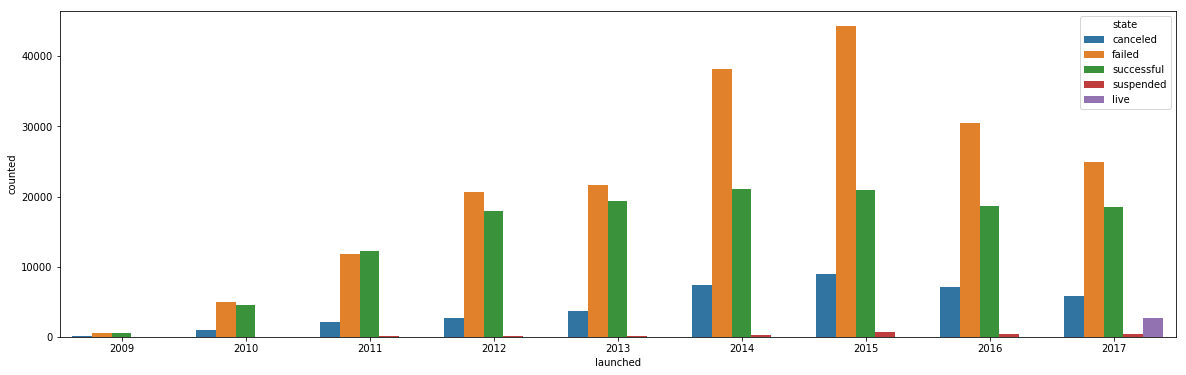

In [17]:
plt.figure(figsize=(20,6))
launched_counted_plot = sns.barplot(x='launched', y='counted', hue = 'state', data=year_state_counted)

Now, dates in the dataset will be prepared to make new column being a result of subtraction of deadline date and launch date.

In [18]:
cleaned_data['duration'] = (cleaned_data['deadline'] - cleaned_data['launched']).dt.days

Few columns still contains string. We cannot work with text variables so we change values of those numeric variables into numeric. We will do it not only with state column but with other text features also.

In [19]:
cleaned_data

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,55
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00,34
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00,19
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00,44
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00,34
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00,29


In [20]:
#category_dummies = pd.get_dummies(cleaned_data.category)
main_category_dummies = pd.get_dummies(cleaned_data.main_category)
currency_dummies = pd.get_dummies(cleaned_data.currency)
country_dummies = pd.get_dummies(cleaned_data.country)
encoded_df = pd.concat([cleaned_data, 
                        #category_dummies, 
                        main_category_dummies, currency_dummies, country_dummies], axis=1)

In [21]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374724 entries, 0 to 378660
Data columns (total 67 columns):
ID                  374724 non-null int64
name                374724 non-null object
category            374724 non-null object
main_category       374724 non-null object
currency            374724 non-null object
deadline            374724 non-null datetime64[ns]
goal                374724 non-null float64
launched            374724 non-null datetime64[ns]
pledged             374724 non-null float64
state               374724 non-null object
backers             374724 non-null int64
country             374724 non-null object
usd pledged         374724 non-null float64
usd_pledged_real    374724 non-null float64
usd_goal_real       374724 non-null float64
duration            374724 non-null int64
Art                 374724 non-null uint8
Comics              374724 non-null uint8
Crafts              374724 non-null uint8
Dance               374724 non-null uint8
Design         

# 2.3. Currencies

Projects are established in many countries with various currencies. Let's check quantity of projects financed by money of each of those currencies.

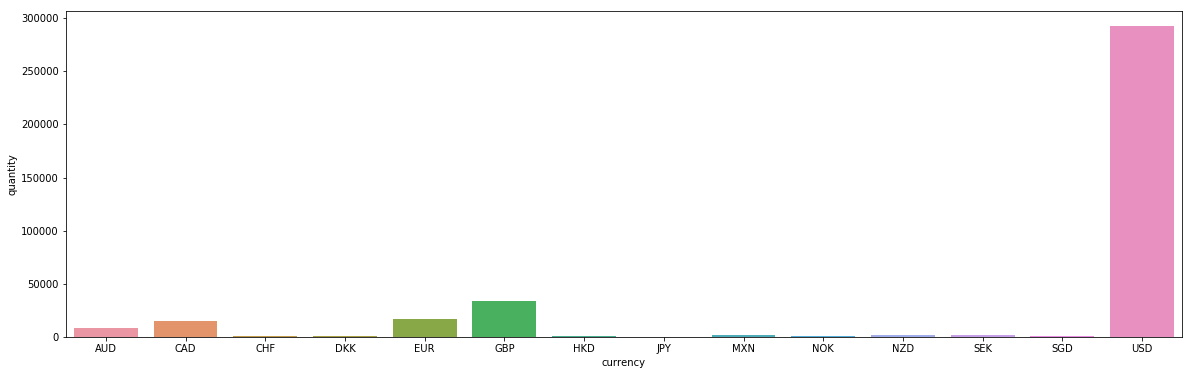

In [22]:
currency_grouped = encoded_df.groupby('currency').size().to_frame('quantity').reset_index()
plt.figure(figsize=(20,6))
ax = sns.barplot(x='currency', y='quantity', data=currency_grouped)

In the dataset, there are data about projects financed by fourteen distinct currencies. Only five of them are notable and the US dollar shows an outright dominance. We are going to check quantity of projects in different currencies - if number of project in a specific currency is low, we cannot analyse it in a quantitative way. 

In [23]:
currency_grouped

,currency,quantity
0,AUD,7833
1,CAD,14750
2,CHF,760
3,DKK,1113
4,EUR,17214
5,GBP,33654
6,HKD,618
7,JPY,39
8,MXN,1750
9,NOK,708


Subjectively, there were choosen columns that have assigned values of 1 less times than 1000 and those columns were dropped from a dataframe. 
TODO - to check how high the treshold should be

In [24]:
dropped_currencies = encoded_df.drop(columns = ['CHF', 'HKD', 'JPY', 'NOK', 'SGD', 'SGD'])

# 2.4. Categories

Analogously to the currency analysis - there were checked quantities of positive values of columns based on informations from the main_category feature.

In [25]:
main_category_grouped = dropped_currencies.groupby('main_category').size().to_frame('quantity').reset_index()
main_category_grouped

,main_category,quantity
0,Art,28132
1,Comics,10816
2,Crafts,8806
3,Dance,3767
4,Design,30056
5,Fashion,22804
6,Film & Video,62683
7,Food,24594
8,Games,35208
9,Journalism,4750


Every category exceed the treshold.

In [26]:
print(dropped_currencies.main_category.unique())

['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']


According to fact category columns' positive values are not numerous, those columns were passed in the first iteration, especially including the knowledge they are correlated with main_category columns.

We pass category feature for now because it can duplicate the power of other feature (main_category). In the next iteration we will check which feature of those two is a better one.

In [27]:
#year_state_counted = cleaned_data.groupby([cleaned_data['launched'].dt.year, 'state']).size().to_frame('counted').reset_index()
#year_state_counted

# 2.5. Country

Analogously to the currency analysis - there were checked quantities of positive values of columns based on informations from the country feature.

In [28]:
country_grouped = dropped_currencies.groupby('country').size().to_frame('quantity').reset_index()
country_grouped

,country,quantity
0,AT,597
1,AU,7833
2,BE,617
3,CA,14750
4,CH,760
5,DE,4169
6,DK,1113
7,ES,2275
8,FR,2938
9,GB,33654


A few of countries have not enough projects to exceed the treshold so they were exluded.

In [29]:
dropped_countries = dropped_currencies.drop(columns = ['AT', 'BE', 'CH', 'HK', 'IE', 'JP', 'LU', 'NO', 'SG'])

# 2.6. Backers

In [30]:
backers_grouped = dropped_countries.groupby('backers').size().to_frame('quantity').reset_index()
backers_grouped

,backers,quantity
0,0,51768
1,1,34847
2,2,23187
3,3,16051
4,4,12065
5,5,9712
6,6,8134
7,7,7010
8,8,6195
9,9,5550


According to intuition - there are more projects with small quantity of backers than with big quantity. 
During building model there will be checked if this feature changes number of correct predictions. 

# 2.7. Collected money and the goal

The feature implying colleted money is usd_pledged_real. It contains size of funds after currency conversion to USD. 
The similar situation is related with the goal value - usd_goal_real feature values are converted to USD.

# 2.8. Duration

Duration feature is a feature prepared in the previous section (2.2).
It is a result of subtraction of deadline date and launch date (in days).

In [31]:
dropped_countries['duration'].min()

0

In [32]:
dropped_countries['duration'].max()

91

# 2.9. Real columns

Columns with a word 'real' in their name are analogous columns to those without 'real' in their name but are converted to USD. It allows to compare projects financed in different currencies. As those columns withour 'real' duplicates information that is included in columns with 'real', it was decided to leave only one categories of financial columns - with 'real'.

In [33]:
real_df = dropped_countries.drop(columns = ['usd pledged', 'goal', 'pledged'])

According the fact the goal of the project is to assess if Kickstarter projects will be successful or not, we cannot include 'usd_pledged_real' variable in a model - we won't have information about final collected money when project is not closed. It was decided do exclude 'usd_pledged_real' variable.

In [34]:
corrected_real_df = real_df.drop(columns = ['usd_pledged_real'])

# 3. Modelling

Not closed projects were excluded from training sample (those which have 'state' variable equal to 'live' value). In the end, those projects' assigned values (predicted success or fail) are the goal of the project.

In [35]:
filtered_state = corrected_real_df[corrected_real_df['state']!='live']
filtered_state = filtered_state.loc[filtered_state.state != 'suspended']

As the 'canceled' state implies that project was not successful, it was decided to consider it as 'failed' project.

In [36]:
filtered_state.loc[filtered_state.state == 'canceled', 'state'] = 'failed'

In [37]:
le = preprocessing.LabelEncoder()
le.fit(filtered_state['state'])
filtered_state['state_no'] = le.transform(filtered_state['state']) 

Features that are not considered to be used in a modelling were excluded.

In [38]:
dropped_to_model = filtered_state.drop(columns = [#'category', 
    'main_category', 'currency', 'country', 'deadline',
    'launched', 'state', 'ID', 'name'])

Final list of features that take part in a modelling process:

In [39]:
list(dropped_to_model)

['category',
 'backers',
 'usd_goal_real',
 'duration',
 'Art',
 'Comics',
 'Crafts',
 'Dance',
 'Design',
 'Fashion',
 'Film & Video',
 'Food',
 'Games',
 'Journalism',
 'Music',
 'Photography',
 'Publishing',
 'Technology',
 'Theater',
 'AUD',
 'CAD',
 'DKK',
 'EUR',
 'GBP',
 'MXN',
 'NZD',
 'SEK',
 'USD',
 'AU',
 'CA',
 'DE',
 'DK',
 'ES',
 'FR',
 'GB',
 'IT',
 'MX',
 'NL',
 'NZ',
 'SE',
 'US',
 'state_no']

The sample was splitted to train sample and test sample. 

In [40]:
X = dropped_to_model.iloc[:,1:-1]
y = dropped_to_model['state_no']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

Next, a model was created using xgboost algotrithm. A pink warning below modelling cell is generated by a conflict of scikit-learn and latest version of numpy. It was decided to not downgrade the numpy and to accept the warning.

In [41]:
xgb = XGBClassifier()
model = xgb.fit(X_train, y_train)
pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification report was created.

In [42]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.96      0.94      0.95     71122
          1       0.89      0.92      0.91     39940

avg / total       0.93      0.93      0.93    111062



Gini value was calucalted basing on auc value.

In [43]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print('Gini: ', auc*2 - 1) 

Gini:  0.9651120532208566


Gini value equals to 0.965. It is suspected to be too high so the model is need to be double checked in the future.

A chart below shows model's features importance.

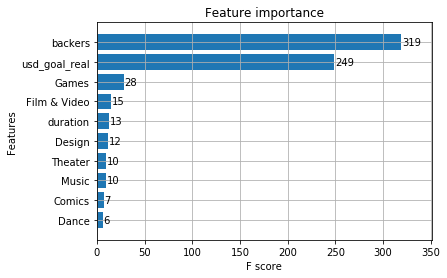

In [44]:
xgboost.plot_importance(model, max_num_features=10, height=0.8)

The most important features seem to be 'backers', 'usd_goal_real', 'duration' and few of project categories. Countries and currencies are not comparable to them.

In [45]:
list(dropped_to_model)

['category',
 'backers',
 'usd_goal_real',
 'duration',
 'Art',
 'Comics',
 'Crafts',
 'Dance',
 'Design',
 'Fashion',
 'Film & Video',
 'Food',
 'Games',
 'Journalism',
 'Music',
 'Photography',
 'Publishing',
 'Technology',
 'Theater',
 'AUD',
 'CAD',
 'DKK',
 'EUR',
 'GBP',
 'MXN',
 'NZD',
 'SEK',
 'USD',
 'AU',
 'CA',
 'DE',
 'DK',
 'ES',
 'FR',
 'GB',
 'IT',
 'MX',
 'NL',
 'NZ',
 'SE',
 'US',
 'state_no']

In [46]:
dropped_to_model

,category,backers,usd_goal_real,duration,Art,Comics,Crafts,Dance,Design,Fashion,...,ES,FR,GB,IT,MX,NL,NZ,SE,US,state_no
0,Poetry,0,1533.95,58,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Narrative Film,15,30000.00,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Narrative Film,3,45000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Music,1,5000.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Film & Video,14,19500.00,55,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,Restaurants,224,50000.00,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,Food,16,1000.00,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
7,Drinks,40,25000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,Product Design,58,125000.00,34,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,Documentary,43,65000.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


The correlation matrix was visualised below.

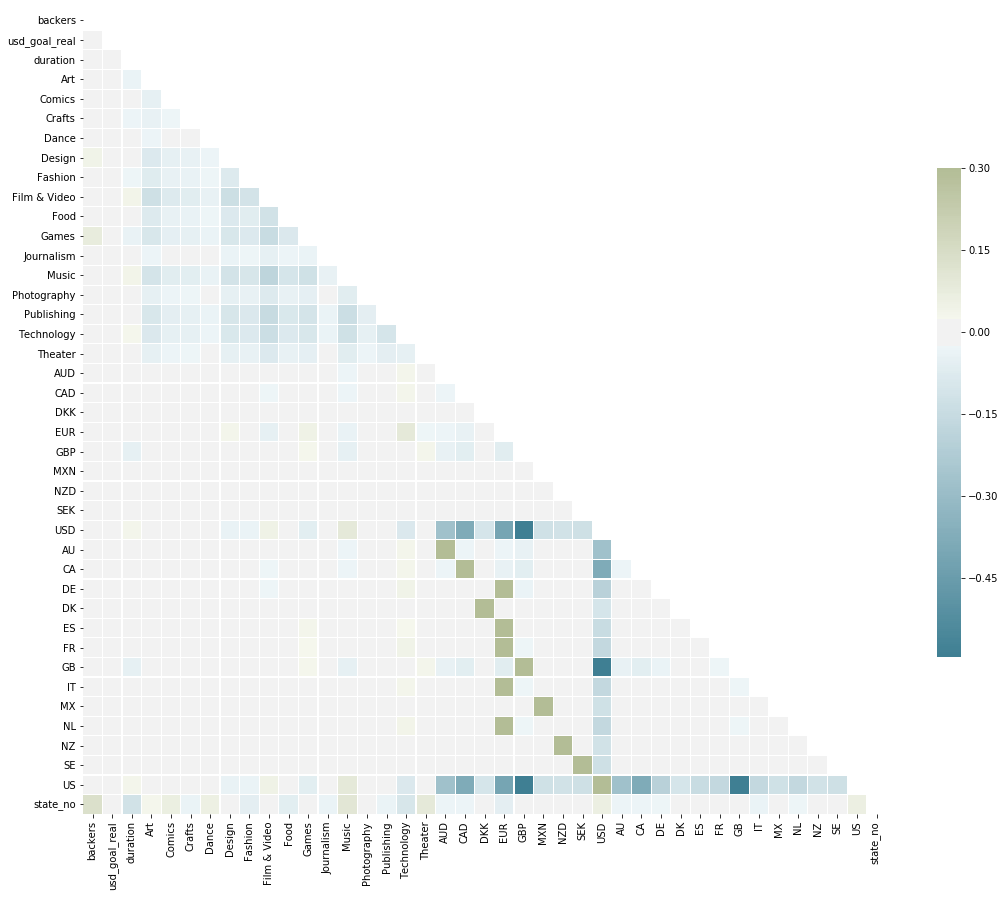

In [47]:
corr = dropped_to_model.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(220, 100, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.05, cbar_kws={"shrink": .5})

In [48]:
corr

,backers,usd_goal_real,duration,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,ES,FR,GB,IT,MX,NL,NZ,SE,US,state_no
backers,1.000000,0.004725,-0.001701,-0.020137,0.005405,-0.013420,-0.007048,0.043290,-0.012507,-0.019482,...,-0.002852,0.001299,-0.007412,-0.004960,-0.005948,-0.002500,-0.002401,-0.000697,0.013024,0.129199
usd_goal_real,0.004725,1.000000,0.022424,-0.001421,-0.003888,-0.004754,-0.003192,-0.000754,-0.005076,0.014868,...,0.000591,0.002930,-0.000581,0.002698,-0.001772,0.005053,-0.001118,-0.000222,-0.003582,-0.023708
duration,-0.001701,0.022424,1.000000,-0.035317,-0.000615,-0.031989,-0.008618,0.005561,-0.027184,0.039655,...,-0.000450,0.007929,-0.052904,0.019886,0.013129,-0.004245,-0.011589,-0.004421,0.034801,-0.118445
Art,-0.020137,-0.001421,-0.035317,1.000000,-0.049260,-0.044153,-0.028803,-0.083964,-0.072434,-0.128250,...,-0.001047,-0.005275,0.004964,-0.003660,0.004665,-0.002743,-0.003016,-0.002605,0.007809,0.030607
Comics,0.005405,-0.003888,-0.000615,-0.049260,1.000000,-0.026726,-0.017435,-0.050824,-0.043845,-0.077631,...,-0.005825,-0.009213,-0.005787,-0.006975,-0.003223,-0.012122,-0.006571,-0.005865,0.017382,0.065937
Crafts,-0.013420,-0.004754,-0.031989,-0.044153,-0.026726,1.000000,-0.015627,-0.045555,-0.039299,-0.069583,...,-0.002686,0.001178,0.007253,-0.004127,0.005616,-0.001580,0.001634,-0.001365,-0.009337,-0.037805
Dance,-0.007048,-0.003192,-0.008618,-0.028803,-0.017435,-0.015627,1.000000,-0.029718,-0.025637,-0.045393,...,-0.005355,-0.003386,-0.005596,-0.006268,0.002664,-0.003841,-0.002785,-0.004508,0.018594,0.055533
Design,0.043290,-0.000754,0.005561,-0.083964,-0.050824,-0.045555,-0.029718,1.000000,-0.074734,-0.132322,...,0.004704,0.008405,0.000599,0.016391,-0.004984,0.013591,0.006667,0.004407,-0.042333,-0.002530
Fashion,-0.012507,-0.005076,-0.027184,-0.072434,-0.043845,-0.039299,-0.025637,-0.074734,1.000000,-0.114152,...,0.007877,0.009807,0.012301,0.015089,-0.005443,0.012662,0.002687,0.003490,-0.032894,-0.059249
Film & Video,-0.019482,0.014868,0.039655,-0.128250,-0.077631,-0.069583,-0.045393,-0.132322,-0.114152,1.000000,...,-0.019300,-0.017536,0.003482,-0.021736,0.001920,-0.021894,-0.006018,-0.009549,0.051130,0.016650


Few of features are correlated so they could be excluded from learning the xgboost model.